In [8]:
import sagemaker
from sagemaker import get_execution_role
import torch
import torch.nn as nn
import torch.functional as f
import torch.optim as optim
import pandas as pd
from torch.utils.data import random_split, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import time
import numpy as np

In [9]:
#Read and split dataset
bucket = 'sagemaker-ann-fyp'
data_key = 'complete_dataset.csv' 
travel_data = 's3://{}/{}'.format(bucket,data_key)

full_dataset = pd.read_csv(travel_data)

dataset_features = ['hod','sourcelong','sourcelat','dstlong','dstlat','distance']
X = full_dataset[dataset_features]
y = full_dataset['mean_travel_time']

train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=0)

train_X = torch.FloatTensor(train_X.values)
test_X = torch.FloatTensor(test_X.values)

train_y = torch.FloatTensor(train_y.values)
test_y = torch.FloatTensor(test_y.values)

print(train_X)

tensor([[ 1.2000e+01, -3.1432e-01,  5.1517e+01, -2.6322e-01,  5.1623e+01,
          1.8053e+04],
        [ 1.5000e+01, -9.4330e-02,  5.1318e+01, -1.0651e-01,  5.1388e+01,
          9.7661e+03],
        [ 1.8000e+01, -4.6590e-02,  5.1419e+01, -1.3372e-01,  5.1398e+01,
          8.8624e+03],
        ...,
        [ 1.3000e+01, -3.1403e-01,  5.1505e+01, -1.9315e-01,  5.1521e+01,
          1.2252e+04],
        [ 7.0000e+00, -2.3532e-01,  5.1397e+01, -2.7983e-01,  5.1389e+01,
          5.5678e+03],
        [ 0.0000e+00, -1.5530e-01,  5.1339e+01, -1.6564e-01,  5.1396e+01,
          7.4586e+03]])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
#Custom Data loaders
train_data = TensorDataset(train_X,train_y)
test_data = TensorDataset(test_X,test_y)

batch_size = 200

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

#print(next(iter(train_loader)))

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super(MLP, self).__init__()
        
        assert out_dim==1, 'out_dim must be 1'
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        
        #creating a module list of hidden layers & adding the input layer as 1st layer in the list
        self.hidden_layers = nn.ModuleList([nn.Linear(self.in_dim, self.hidden_dim[0])])
        
        #create a list of hidden layers by pairing hidden layer dims, and a for loop to create layers 
        #depending on given list of dimensions
        hidden_layer_sizes = zip(self.hidden_dim[:-1], self.hidden_dim[1:])
        for (layer_in, layer_out) in hidden_layer_sizes:
            self.hidden_layers.extend([nn.Linear(layer_in, layer_out)])
        #creates the last layer    
        self.output = nn.Linear(self.hidden_dim[-1], self.out_dim)
        
    def forward(self, x):
         #a for loop to loop through each layer in the hidden layer module list
        for h_layer in iter(self.hidden_layers):
            x = torch.relu(h_layer(x))
        
        x = self.output(x)
        
        x = x.squeeze(1)
        return x

In [11]:
def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [12]:
mlp = MLP(train_X.shape[1], [16,18,20,14,10,6], 1).to(device)
print(mlp)
optimizer = optim.Adam(mlp.parameters())

MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=18, bias=True)
    (2): Linear(in_features=18, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=14, bias=True)
    (4): Linear(in_features=14, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=6, bias=True)
  )
  (output): Linear(in_features=6, out_features=1, bias=True)
)


In [55]:
#early stopping
early_stopping = True
tol = 0.0001
patience = 10

#training phase
epochs = 1000
start_time = time.time()

#to plot loss curve after training
train_losses = []
valid_losses = []
early_stop_epochs = 0

for epoch in range(epochs):
    train_loss = 0
    start_time = time.time()
    mlp.train()
    train_num_batch = len(train_loader)
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = mlp(batch_x)

        loss = mae_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min
        
        train_loss += loss.item()

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id+1, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    test_num_batch = len(test_loader)
    
    for batch_id, (batch_x, batch_y) in enumerate(test_loader):
    
        y_pred = mlp(batch_x)
        loss = mae_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    #valid_loss /= num_batch
    #valid_losses.append(valid_loss)
    valid_loss /= test_num_batch
    valid_losses.append(valid_loss)
    train_loss /= train_num_batch
    train_losses.append(train_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp_timePrediction_pytorch.pt')  
    
    print('Valid Loss:{:.4f}'.format(valid_loss))

    #early stopping
    if early_stopping and epoch > 0:
        if np.abs(valid_losses[-1] - valid_losses[-2]) < tol:
            early_stop_epochs += 1
        else:
            early_stop_epochs = 0
        if early_stop_epochs == patience:
            print("Validation loss has not changed more than {} for {} epochs. Stopping...".format(tol, patience))
            break
    
runtime = time.time() - start_time

print("Total Runtime Elapsed: {:.0f} hours {:.0f} minutes {:.2f} seconds.".format(runtime//3600, runtime%3600//60, runtime%3600%60))

Epoch:1 Batch:562/562 Loss:463.2852 Time:0m3.20s
Valid Loss:463.9095
Epoch:2 Batch:562/562 Loss:457.3598 Time:0m2.90s
Valid Loss:459.6653
Epoch:3 Batch:562/562 Loss:456.8597 Time:0m2.65s
Valid Loss:454.4956
Epoch:4 Batch:562/562 Loss:371.5927 Time:0m2.80s
Valid Loss:441.7808
Epoch:5 Batch:562/562 Loss:397.1981 Time:0m2.99s
Valid Loss:415.8518
Epoch:6 Batch:562/562 Loss:391.4636 Time:0m2.76s
Valid Loss:415.9493
Epoch:7 Batch:562/562 Loss:430.2720 Time:0m2.73s
Valid Loss:420.5980
Epoch:8 Batch:562/562 Loss:434.4097 Time:0m2.72s
Valid Loss:413.2856
Epoch:9 Batch:562/562 Loss:424.9773 Time:0m2.84s
Valid Loss:411.7022
Epoch:10 Batch:562/562 Loss:415.9428 Time:0m2.75s
Valid Loss:413.2054
Epoch:11 Batch:562/562 Loss:365.3704 Time:0m2.64s
Valid Loss:411.6132
Epoch:12 Batch:562/562 Loss:430.2033 Time:0m2.71s
Valid Loss:411.1373
Epoch:13 Batch:562/562 Loss:430.8063 Time:0m2.60s
Valid Loss:411.0117
Epoch:14 Batch:562/562 Loss:423.0754 Time:0m2.70s
Valid Loss:410.1344
Epoch:15 Batch:562/562 Loss:4

Epoch:118 Batch:562/562 Loss:347.0050 Time:0m2.74s
Valid Loss:356.1024
Epoch:119 Batch:562/562 Loss:339.8937 Time:0m2.92s
Valid Loss:364.8943
Epoch:120 Batch:562/562 Loss:372.6199 Time:0m2.70s
Valid Loss:357.6114
Epoch:121 Batch:562/562 Loss:371.6741 Time:0m2.88s
Valid Loss:354.7450
Epoch:122 Batch:562/562 Loss:385.8467 Time:0m2.80s
Valid Loss:354.2206
Epoch:123 Batch:562/562 Loss:385.3150 Time:0m2.75s
Valid Loss:355.9921
Epoch:124 Batch:562/562 Loss:372.2783 Time:0m2.91s
Valid Loss:363.1824
Epoch:125 Batch:562/562 Loss:366.5442 Time:0m2.69s
Valid Loss:359.0535
Epoch:126 Batch:562/562 Loss:339.8680 Time:0m2.60s
Valid Loss:356.0379
Epoch:127 Batch:562/562 Loss:336.1526 Time:0m2.85s
Valid Loss:358.7840
Epoch:128 Batch:562/562 Loss:340.0040 Time:0m3.08s
Valid Loss:357.9463
Epoch:129 Batch:562/562 Loss:300.3244 Time:0m2.85s
Valid Loss:361.0240
Epoch:130 Batch:562/562 Loss:357.4390 Time:0m2.65s
Valid Loss:363.8324
Epoch:131 Batch:562/562 Loss:340.1613 Time:0m2.67s
Valid Loss:355.1009
Epoch:

Epoch:348 Batch:562/562 Loss:337.6299 Time:0m2.81s
Valid Loss:364.6035
Epoch:349 Batch:562/562 Loss:348.4239 Time:0m2.81s
Valid Loss:353.6145
Epoch:350 Batch:562/562 Loss:377.5633 Time:0m2.68s
Valid Loss:352.4140
Epoch:351 Batch:562/562 Loss:378.6254 Time:0m2.73s
Valid Loss:355.8933
Epoch:352 Batch:562/562 Loss:318.8699 Time:0m2.68s
Valid Loss:351.9946
Epoch:353 Batch:562/562 Loss:346.4871 Time:0m2.63s
Valid Loss:364.8347
Epoch:354 Batch:562/562 Loss:379.5801 Time:0m2.62s
Valid Loss:349.0688
Epoch:355 Batch:562/562 Loss:327.5710 Time:0m2.74s
Valid Loss:353.6704
Epoch:356 Batch:562/562 Loss:327.8812 Time:0m2.64s
Valid Loss:351.5358
Epoch:357 Batch:562/562 Loss:354.9949 Time:0m2.72s
Valid Loss:353.1819
Epoch:358 Batch:562/562 Loss:358.9379 Time:0m2.80s
Valid Loss:352.5605
Epoch:359 Batch:562/562 Loss:365.6902 Time:0m2.73s
Valid Loss:354.5874
Epoch:360 Batch:562/562 Loss:395.6715 Time:0m2.71s
Valid Loss:356.8147
Epoch:361 Batch:562/562 Loss:395.2058 Time:0m2.61s
Valid Loss:350.4435
Epoch:

Epoch:578 Batch:562/562 Loss:389.0231 Time:0m3.14s
Valid Loss:351.0406
Epoch:579 Batch:562/562 Loss:342.9587 Time:0m2.81s
Valid Loss:351.6851
Epoch:580 Batch:562/562 Loss:401.0274 Time:0m2.92s
Valid Loss:358.4056
Epoch:581 Batch:562/562 Loss:354.7949 Time:0m3.36s
Valid Loss:365.3910
Epoch:582 Batch:562/562 Loss:387.6700 Time:0m3.01s
Valid Loss:357.3125
Epoch:583 Batch:562/562 Loss:358.5948 Time:0m3.15s
Valid Loss:348.5843
Epoch:584 Batch:562/562 Loss:347.7180 Time:0m2.78s
Valid Loss:349.3565
Epoch:585 Batch:562/562 Loss:344.5054 Time:0m2.77s
Valid Loss:352.2253
Epoch:586 Batch:562/562 Loss:348.2793 Time:0m2.70s
Valid Loss:351.7997
Epoch:587 Batch:562/562 Loss:323.4650 Time:0m2.71s
Valid Loss:350.0773
Epoch:588 Batch:562/562 Loss:335.7855 Time:0m2.58s
Valid Loss:353.4071
Epoch:589 Batch:562/562 Loss:350.7881 Time:0m2.68s
Valid Loss:350.9905
Epoch:590 Batch:562/562 Loss:376.1154 Time:0m2.66s
Valid Loss:353.5162
Epoch:591 Batch:562/562 Loss:354.6173 Time:0m2.68s
Valid Loss:349.1171
Epoch:

KeyboardInterrupt: 

Minimum Validation Loss is 348.3723
Best iteration: 608


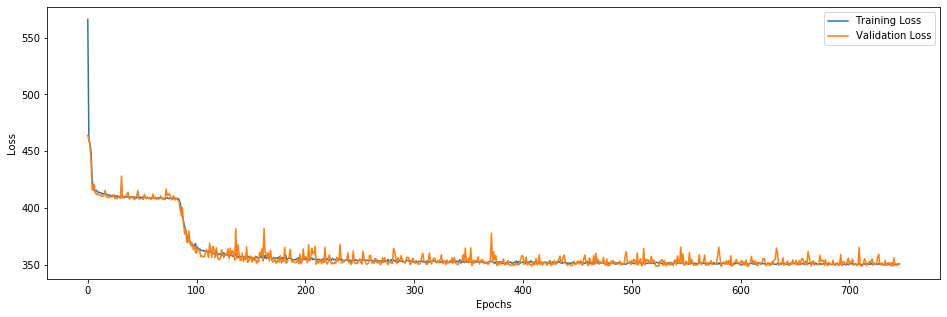

In [56]:
#plot validation loss curve, this may help to notice overfitting
plt.figure(figsize=(16,5))
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc = 0)

print('Minimum Validation Loss is {:.4f}'.format(min(valid_losses)))
print("Best iteration: {}".format(np.argmin(valid_losses) + 1))

#plt.ylim(0,max(valid_losses)+0.02)
#plt.plot(valid_losses)
#print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

In [13]:
x_test = np.array([[6,0.031180191,51.51122955,-0.044059634,51.54066292,9681]])
input_test = torch.tensor(x_test, dtype=torch.float, device=device )

mlp_model = mlp.load_state_dict(torch.load('mlp_timePrediction_pytorch.pt'))
y_pred = mlp(input_test)
r
print(y_pred)
#Expected reading should be 911.37

[1152.3823]
